# Example 3 - Plotting DO Profiles (and more) from NetCDF data files
*Written by Sage Lichtenwalner, Rutgers University, June 7, 2018, with help from Friedrich Knuth*

*Verified by Leila Belabbassi (to work with Pangeo), July 9, 2018*

In this example we show how to programmatically download and plot colored depth profilers using OOI NetCDF data. We will use data from the Cabled Array [Oregon Slope Base Shallow Profiler Mooring](http://oceanobservatories.org/site/RS01SBPS/) Shallow Profiler CTD. 

For the instrument in this example, we will need the Reference Designator, data delivery method and stream name to make the request to the M2M API, which we can grab from the following page...
http://ooi.visualocean.net/instruments/view/RS01SBPS-SF01A-2A-CTDPFA102

*NOTE: Cabled CTD is a high resolution instrument. Therefore, we probably don't want to grab too much data at once since it can take a while to load or process plots for even a month of data.*


## Requesting and loading data

As in the previous examples, first we need to make a request tp generate the files from the OOI Data Portal using the API.

In [30]:
USERNAME = 'YOUR API USERNAME'
TOKEN =  'YOUR API TOKEN'

In [6]:
# First, we need to add some more Python libraries
import requests

In [7]:
# Instrument Information
site = 'RS01SBPS'
node = 'SF01A'
instrument = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

# API base url
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Create the full request URL
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# All of the following are optional
params = {
  'beginDT':'2016-10-01T00:00:00.000Z',
  'endDT':'2016-10-02T01:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

### WARNING: 
#### Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [8]:
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()
# print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/leila.ocean@gmail.com/20180709T204930-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html


Now that we have generated the request, let's save the THREDDS url so we can run this notebook again later without having to make a new request.  (If you forget to do this, you can always get the url from the email sent by the system.)

In [9]:
# 2016-10-25
url ='https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180608T174056-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'


Remember, we can't proceed with the rest of this notebook until the data files have been generated successfully.  We can use the following code to make sure the data is ready.

In [11]:
# import time
%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800):
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
            time.sleep(1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 45.3 µs
request completed


## Profile Timeseries Plot

First we need to find the available data files in the web directory created as part of our request.

In [13]:
import re
import os

To do this, we will parse the THREDDS server to get a list of all of the available NetCDF files. 

Remember, each deployment is separated into a separate file, but if you request a small time period, there may only be one file.  By finding all files available, we can concatenate them all together if desired.

In [14]:
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180608T174056-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20161025T000000.717281-20161101T005959.173113.nc']

Next we can load all files into a single [dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset) using xarray.

In [15]:
import xarray as xr

In [16]:
# Load the data files
ds = xr.open_mfdataset(datasets)

In [17]:
# By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
ds = ds.swap_dims({'obs': 'time'}) 

# Sort the data
ds = ds.sortby('time'); 

# Optional, this is used to optimize data processing
ds = ds.chunk({'time': 100}) 

ds

<xarray.Dataset>
Dimensions:                                 (time: 605351)
Coordinates:
    obs                                     (time) int32 dask.array<shape=(605351,), chunksize=(100,)>
  * time                                    (time) datetime64[ns] 2016-10-25T00:00:00.717281280 ...
    seawater_pressure                       (time) float64 dask.array<shape=(605351,), chunksize=(100,)>
    lat                                     (time) float64 dask.array<shape=(605351,), chunksize=(100,)>
    lon                                     (time) float64 dask.array<shape=(605351,), chunksize=(100,)>
Data variables:
    deployment                              (time) int32 dask.array<shape=(605351,), chunksize=(100,)>
    id                                      (time) |S64 dask.array<shape=(605351,), chunksize=(100,)>
    conductivity                            (time) float64 dask.array<shape=(605351,), chunksize=(100,)>
    driver_timestamp                        (time) datetime64[ns] d

And now we can plot the results.  Let's start by creating a scatterplot of Temperature.

In [18]:
import matplotlib.pyplot as plt

In [19]:
# Extract the values
dtime = ds['time'].values
pressure = ds['seawater_pressure'].values
temperature = ds['seawater_temperature'].values
salinity = ds['practical_salinity'].values
oxygen = ds['corrected_dissolved_oxygen'].values

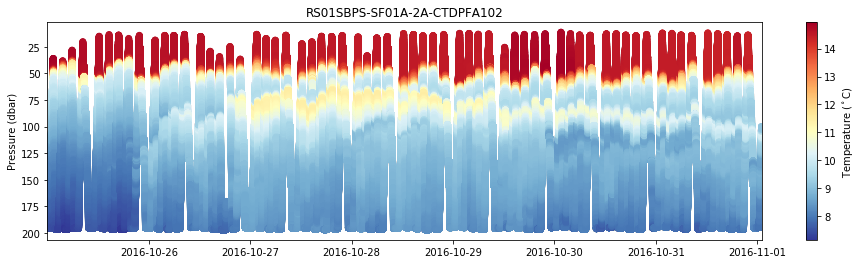

In [20]:
# Scatterplot of Temperature
fig,ax1 = plt.subplots(1,1,figsize=(16,4))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('RS01SBPS-SF01A-2A-CTDPFA102');

Now, let's plot Salinity and Oxygen as well.

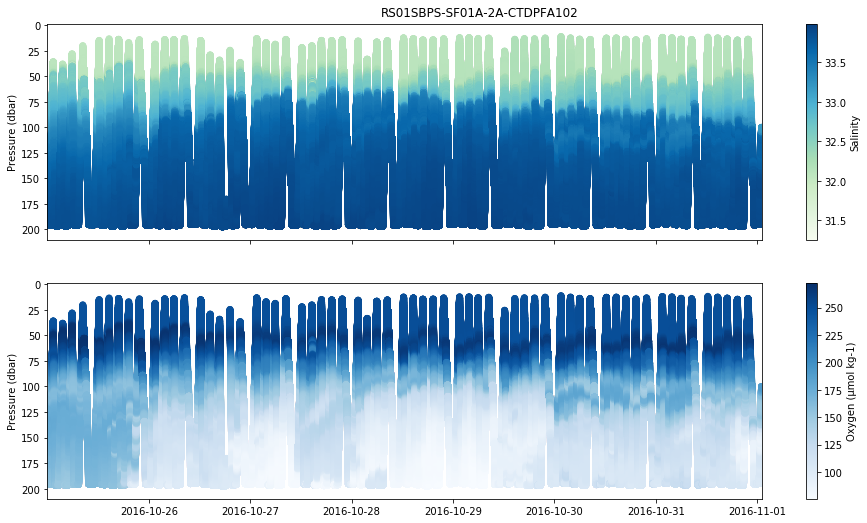

In [21]:
# Scatterplots of Salinity and Oxygen
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=salinity, cmap='GnBu') 
sc2 = ax2.scatter(dtime, pressure, c=oxygen, cmap='Blues')

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Salinity')

cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Oxygen (%s)' % ds['corrected_dissolved_oxygen'].units) # Let's grab the units attribute

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('RS01SBPS-SF01A-2A-CTDPFA102')
fig.subplots_adjust(top=0.95);

## Changing Colormaps

While there are a lot of [Matplotlib colormaps](https://matplotlib.org/users/colormaps.html) to choose, if you want to try something different - and potentially more relevant - check out [cmocean](https://matplotlib.org/cmocean/), which provides a bunch of colormaps specifically designed for oceanographic variables.

Let's remake the above plots with the cmocean suggested colormaps.

In [22]:
import cmocean

/opt/conda/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


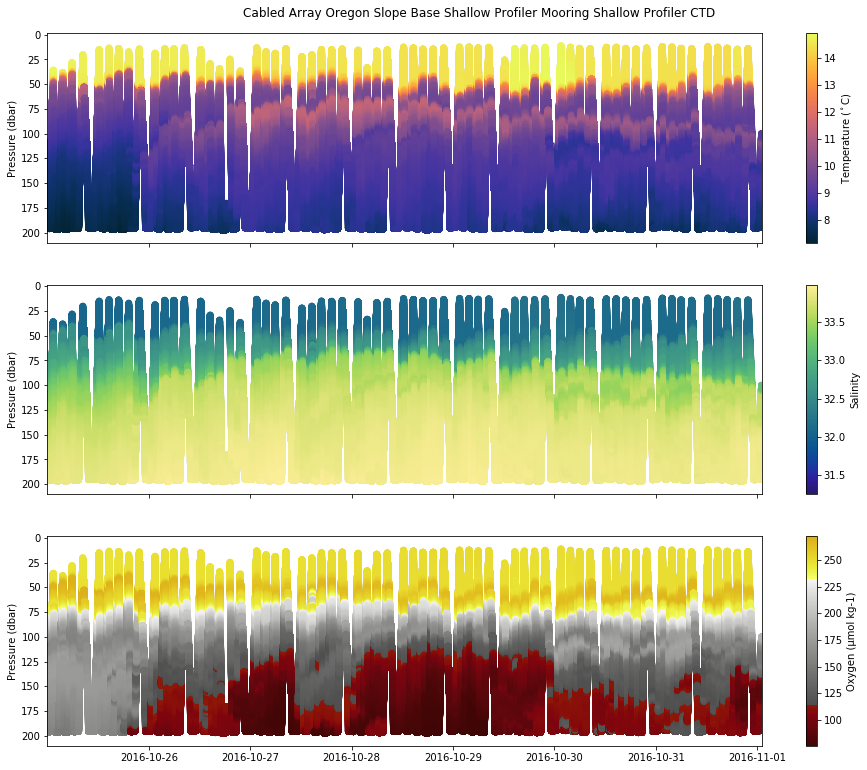

In [23]:
#Temperature, Salinity & Oxygen
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(16,12))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap=cmocean.cm.thermal) 
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap=cmocean.cm.haline) 
sc3 = ax3.scatter(dtime, pressure, c=oxygen, cmap=cmocean.cm.oxy)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

# Add the colorbars
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical')
cbar.ax.set_ylabel('Oxygen (%s)' % ds['corrected_dissolved_oxygen'].units)
cbar.update_ticks()
cbar.formatter.set_useOffset(False)

# Add labels & titles
ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')
ax3.set_ylabel('Pressure (dbar)')

fig.suptitle('Cabled Array Oregon Slope Base Shallow Profiler Mooring Shallow Profiler CTD')
fig.subplots_adjust(top=0.95);


Note, you can add vmin/vmax to the `plt.scatter()` command to set the colorbar range.  When using the cmocean DO colorscale, a good limit might be 0 to 300, which would make 20% of the color map that is red cover the range between 0-60, roughly the range for hypoxic conditions.

If you change the color axis limits, you should also add `extend='both'` to make it clear that data values in the dataset go beyond the range shown in the color scale.

## Subsetting the dataset

xarray provides a number of ways to [subset a dataset](http://xarray.pydata.org/en/stable/indexing.html).

Because our dataset has time as a dimension, we can use the `sel()` method to extract a specific time range.

In [24]:
a = ds.sel(time=slice('2016-10-26', '2016-10-27'))
a

<xarray.Dataset>
Dimensions:                                 (time: 169759)
Coordinates:
    obs                                     (time) int32 dask.array<shape=(169759,), chunksize=(2,)>
  * time                                    (time) datetime64[ns] 2016-10-26T00:00:00.142420992 ...
    seawater_pressure                       (time) float64 dask.array<shape=(169759,), chunksize=(2,)>
    lat                                     (time) float64 dask.array<shape=(169759,), chunksize=(2,)>
    lon                                     (time) float64 dask.array<shape=(169759,), chunksize=(2,)>
Data variables:
    deployment                              (time) int32 dask.array<shape=(169759,), chunksize=(2,)>
    id                                      (time) |S64 dask.array<shape=(169759,), chunksize=(2,)>
    conductivity                            (time) float64 dask.array<shape=(169759,), chunksize=(2,)>
    driver_timestamp                        (time) datetime64[ns] dask.array<shap

In [25]:
print(ds.time.size)
print(a.time.size)

605351
169759


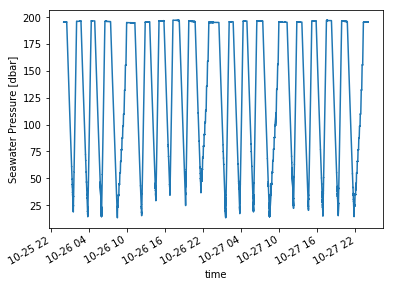

In [26]:
# A quickplot
a['seawater_pressure'].plot();

Note how this extracted data for both October 26th and 27th.  It basically included any times within the specified date range, inclusive.  If we want to be more restrictive, we can specify a full date/time string.

We can also subset the dataset along other parameter ranges using the `where()` method.

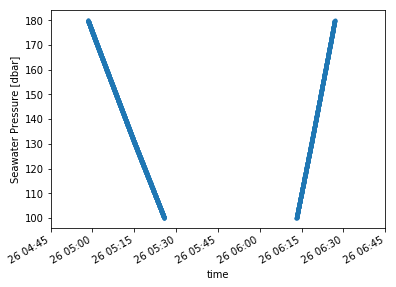

In [27]:
# Extract time range from ds
ds1 = ds.sel(time=slice('2016-10-26 04:45:00', '2016-10-26 06:45:00'))
# Also extract depth range from new a dataset
ds1 = ds.where((ds1.seawater_pressure>=100) & (ds1.seawater_pressure<=180), drop=True)

p = ds1['seawater_pressure'].plot(marker='.', linestyle='None')
# plt.xlim(ds1['time'][0].values,ds1['time'][-1].values);
plt.xlim('2016-10-26 04:45:00','2016-10-26 06:45:00');

## Vertical Profile Plots

Now that we know how to extract a profile (or more) from the dataset, let's create some vertical profile plots.

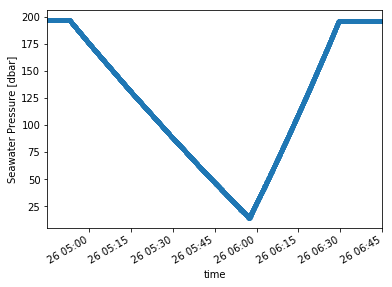

In [28]:
# Extract a full up/down cast
ds2 = ds.sel(time=slice('2016-10-26 04:45:00', '2016-10-26 06:45:00'))

# Check the result
p = ds2['seawater_pressure'].plot(marker='.', linestyle='None')
plt.xlim(ds2['time'][0].values,ds2['time'][-1].values);

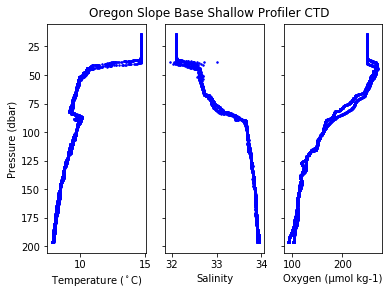

In [29]:
# Now let's create some profile plots
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(ds2.seawater_temperature, ds2.seawater_pressure, 'b.', markersize=3)
ax2.plot(ds2.practical_salinity, ds2.seawater_pressure, 'b.', markersize=3)
ax3.plot(ds2.corrected_dissolved_oxygen, ds2.seawater_pressure, 'b.', markersize=3)

ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('Oxygen (%s)' % ds['corrected_dissolved_oxygen'].units)
ax1.set_ylabel('Pressure (dbar)')

ax1.invert_yaxis()
# ax1.set_ylim(475,0)

fig.suptitle('Oregon Slope Base Shallow Profiler CTD')
fig.subplots_adjust(top=0.92);

And with that, we've reach the depths of this introduction... but we've really just scratched the surface of how to use xarray and matplotlib in Python.

Happy coding!